<a id='top'></a>

#Forest Cover Type Prediction

Submitted by:
* Juanjo Carin
* Tuhin Mahmud
* Vamsi Sakhamuri

Date: July 16, 2015

Kaggle Competition hosted at https://www.kaggle.com/c/forest-cover-type-prediction

##Contents

* <a href='#Objectives'>Objectives: Use cartographic variables to classify forest categories</a>

* <a href='#Loading_and_preparing_the_data'>Loading and preparing the data</a>

* <a href='#k-Nearest_Neighbors'>k-Nearest Neighbors (kNN)</a>

* <a href='#Random_Forests'>Random Forests</a>

* <a href='#Decision_Trees'>Decision Trees</a>

* <a href='#Log_Regression'>Logistic Regression</a>

* <a href='#Results'>Results</a>

* <a href='#Annex_1'>Annex 1: Naive Bayes (NB)</a>

* <a href='#Annex_2'>Annex 2: Plotting the training dataset</a>


<a id='Objectives'></a>

##Objectives: Use cartographic variables to classify forest categories

<a href='#top'>[Back to top]</a>

Random forests? Cover trees? Not so fast, computer nerds. We're talking about the real thing.

In this competition we are asked to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). The actual forest cover type for a given 30 x 30 meter cell was determined from US Forest Service (USFS) Region 2 Resource Information System data. Independent variables were then derived from data obtained from the US Geological Survey and USFS. The data is in raw form (not scaled) and contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.

This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

<a id='Loading_and_preparing_the_data'></a>

##Loading and preparing the data

<a href='#top'>[Back to top]</a>

First we import the libraries we'll use along this project.

In [111]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import ensemble

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature preprocessing.
from sklearn import preprocessing

# SK-learn libraries for dimensionality reduction.
from sklearn.decomposition import PCA

Next we load the training and test data sets.

In [175]:
ff = "train.csv"
f = open(ff)
column_names = f.readline()

data = np.loadtxt(f, delimiter=",")

y, X = data[:, -1].astype('u1'), data[:, :-1]

ff_test = "test.csv" # you will need to edit this directory
f_test = open(ff_test)
column_names_test = f_test.readline() # you'd needs this ordinarily

data_test = np.loadtxt(f_test, delimiter=",")

# note there are no labels here!
X_test = data_test

print 'The test dataset contains {0} observations with {1} features each.'.\
    format(X_test.shape[0], X_test.shape[1])
print '\t(The 1st one is not really a feature but an observation ID.)'
print 'The training dataset contains {0} observations with the same {1} features each.'.\
    format(X.shape[0], X.shape[1])
print 'For this training set we know the corresponding category (forest cover type) of the ' \
      '{0} observations.'.format(y.shape[0])

The test dataset contains 565892 observations with 55 features each.
	(The 1st one is not really a feature but an observation ID.)
The training dataset contains 15120 observations with the same 55 features each.
For this training set we know the corresponding category (forest cover type) of the 15120 observations.


Note that the test set is about 37 times larger than the training set.

To evaluate our performance, we'll split the training set in 2 subsets: **training** data (90%) plus **development** (aka **validation**) data (10%). **Test** data *must not* be used to validate our models, otherwise we might introduce bias: the more times we look at the error rate on the test set , the more we know about the test data, and the more we include our knowledge (that's very specific to that test data set) in the way we solve the problem.

> Nonetheless, in most cases we'll use *cross-validation* to assess how the results of one model generalize to another data set: with this model validation technique, the training data are partitioned into complementary subsets, multiple rounds of cross-validation are performed using different partitions, and the results are averaged.

We also discard the 1st variable (ID), which does not provide any information about the forest cover type.

In [176]:
# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, y = X[shuffle], y[shuffle]

# Split into train (90%) and dev (10%)
train_size = int(X.shape[0] * 0.9)
# Also discard 1st feature (ID number that doesn't provide info about the label)
y_train, X_train = y[:train_size], X[:train_size, 1:]
y_dev, X_dev = y[train_size:], X[train_size:, 1:]
X_test = X_test[:, 1:]
print X_dev.shape, X_train.shape

(1512L, 54L) (13608L, 54L)


The first 10 features of each observation (`Elevation` to `Horizontal_Distance_To_Fire_Points`) are continuous, with different ranges, while the remaining 44 are all binary. 4 of those 44 binary features correspond to `Wilderness Area` (i.e., there are 4 possible types), so any observation will have one 1 and three 0's in those columns. The last 40 features correspond to `Soil Type` (i.e., there are 40 possible types), so any observation will have one 1 and thirty-nine 0's in those columns.

The type of `Wilderness Area` is roughly uniformly distributed among the observations in the training set, with the exception of the 2nd type (only 3.3%).

`Soil Type` is not uniformly distributed at all: many types are quite uncommon, while others account for up to 14.1% of the cases.

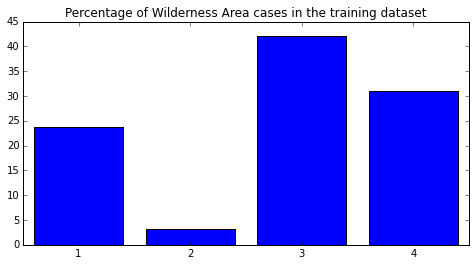

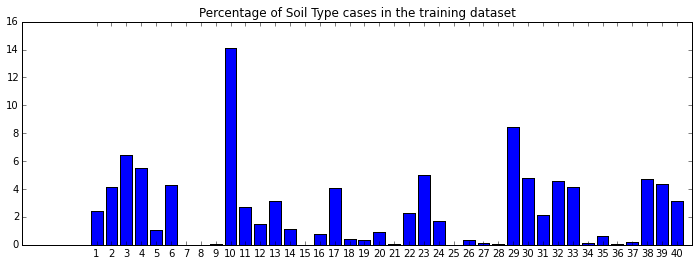

In [182]:
prop_wilderness = 100*X_train[:,10:14].sum(axis=0)/X_train[:,10:14].sum()
prop_soil = 100*X_train[:,14:54].sum(axis=0)/X_train[:,14:54].sum()

plt.figure(figsize=(8, 4))
plt.bar(np.arange(4), prop_wilderness, align="center")
plt.title("Percentage of Wilderness Area cases in the training dataset")
plt.xticks(np.arange(4), np.array([str(i) for i in np.arange(1,5)]))

plt.figure(figsize=(12, 4))
plt.bar(np.arange(40), prop_soil, align="center")
plt.title("Percentage of Soil Type cases in the training dataset")
plt.xticks(np.arange(40), np.array([str(i) for i in np.arange(1,41)]))

plt.show()

For the 10 continuous features we tried `preprocessing.StandardScaler` (to standardize themby removing the mean and scaling to unit variance) as well as `preprocessing.MinMaxScaler` (to standardize them by scaling each feature to a given range; [0,1] in our case, to make it comparable to the binary features).

http://scikit-learn.org/stable/modules/preprocessing.html

In [183]:
# Scale to range [0,1]
    # Only the continuous features
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = np.copy(X_train)
X_dev_minmax = np.copy(X_dev)
X_test_minmax = np.copy(X_test)
X_train_minmax[:, :10] = min_max_scaler.fit_transform(X_train[:, :10])
X_dev_minmax[:, :10]  = min_max_scaler.transform(X_dev[:, :10])
X_test_minmax[:, :10] = min_max_scaler.transform(X_test[:, :10])

# Scale to mean = 0, sd = 1
std_scaler = preprocessing.StandardScaler()
# X_train_std = std_scaler.fit_transform(X_train)
# X_dev_std = std_scaler.transform(X_dev)
# X_test_std = std_scaler.transform(X_test)
    # Only the continuous features
X_train_std = np.copy(X_train)
X_dev_std = np.copy(X_dev)
X_test_std = np.copy(X_test)
X_train_std[:, :10] = std_scaler.fit_transform(X_train[:, :10])
X_dev_std[:, :10] = std_scaler.transform(X_dev[:, :10])
X_test_std[:, :10] = std_scaler.transform(X_test[:, :10])

<a id='k-Nearest_Neighbors'></a>

##k-Nearest Neighbors (kNN)

<a href='#top'>[Back to top]</a>


Because of the different nature of the 54 features (some continuous, some binary and mutually exclusive), we started creating our own distance metric that accounts for these differences to give similar weight to all the features. This new metric combined Euclidean and a variant of Hamming distance, and used the re-scaled version of the continuous variables, as explained in the code below. 

But the results were slightly worse than using the standard Euclidean distance, and after several tests, we discovered that the 44 binary features do not add too much information about the Cover Type. Using that standard Euclidean distance with unscaled data, with all features or just the 10 continuous ones, yields the best results.

The code below just shows some of the results we found.

In [ ]:
# Create a mixed distance metric that accounts for the different characteristic of the features
    # to give a similar weight to all of them
# First 10 features are continuous. The square of differences is applied to the values scaled 
    # to [0,1] (maximum value of the sum = 10)
# Last 44 features correspond to 2 features (wilderness area and soil type), with 4 and 40
    # categories each. A variant of Hamming distance is applied to them, so the maximum value
    # is 2 if two observations differ in both features
# The total distance is the square of the sum of those 12 values, divided by the square of 12,
    # so the maximum distance between any two observations will be 1
# The ranges of the first 10 features may vary in the dev and test datasets, so the distances
    # might be slightly greater than 1
def mixed_distance(x, y):
    return np.sqrt(np.sum((x[:10]-y[:10])**2) + 0.5*np.sum(x[10:14]!=y[10:14]) +
                          0.5*np.sum(x[14:54]!=y[14:54]))/np.sqrt(12)

for k in [1, 3, 5]:
    kNN_mixed = KNeighborsClassifier(n_neighbors=k, metric=mixed_distance)
    kNN_mixed.fit(X_train_minmax, y_train)
    print kNN_mixed.score(X_dev_minmax, y_dev)
    
    kNN_mixed.fit(X_train, y_train)
    print kNN_mixed.score(X_dev, y_dev)
    
    kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    kNN.fit(X_train, y_train)
    print kNN.score(X_dev, y_dev)
    
    kNN.fit(X_train[:,:10], y_train)
    print kNN.score(X_dev[:,:10], y_dev)

In [93]:
####TO BE DELETED?

k=8
kNN = KNeighborsClassifier(n_neighbors=k, metric='euclidean')

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, kNN.score(X_dev_minmax, y_dev))

kNN.fit(X_train, y_train)
print 'Accuracy using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, kNN.score(X_dev, y_dev))

Accuracy using k = 8 neighbor(s) and scaled-to-range data: 0.7834
Accuracy using k = 8 neighbor(s) and non-scaled data:      0.7857


1


(0, 11)

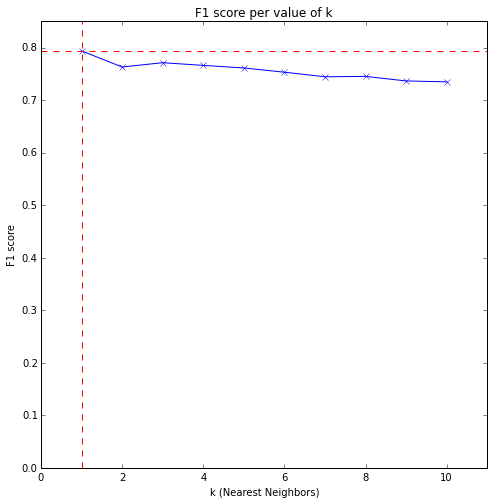

In [109]:
# Estimate by cross-validation the optimal number of neighbors (k)
    # Try between 1 and the number of features (54)
k = {'n_neighbors': np.concatenate([np.arange(1, X_train_minmax.shape[1]+1)]).tolist()}
k = {'n_neighbors': np.concatenate([np.arange(1, 10+1)]).tolist()}
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='f1_macro')
best_param_kNN = GridSearchCV(KNeighborsClassifier(), k, scoring='accuracy')
best_param_kNN.fit(X_train_minmax, y_train)
optimal_k = best_param_kNN.best_params_['n_neighbors']
print optimal_k

f1_vector = np.array([best_param_kNN.grid_scores_[x][1] for x in 
                      range(len(k['n_neighbors']))])
plt.figure(figsize=(8, 8))
plt.plot(k['n_neighbors'], f1_vector, marker='x')
plt.axvline(x=optimal_k, linewidth=1, linestyle='--', color='red')
plt.axhline(y=best_param_kNN.best_score_, linewidth=1, linestyle='--', color='red')
plt.xlabel("k (Nearest Neighbors)")
plt.ylabel("F1 score")
plt.title('F1 score per value of k')
plt.ylim([0, (np.ceil(best_param_kNN.best_score_*20)+1)/20])
plt.xlim([0, len(k['n_neighbors'])+1])

How well does our first model perform on the development data?

In [58]:
k = optimal_k
kNN = KNeighborsClassifier(n_neighbors=k)

kNN.fit(X_train, y_train)
print 'Accuracy using k = {0} neighbor(s) and non-scaled data:      {1:.4f}'.\
    format(k, kNN.score(X_dev, y_dev))
print metrics.accuracy_score(y_true=y_dev, y_pred=kNN.predict(X_dev))

kNN.fit(X_train_std, y_train)
print 'Accuracy using k = {0} neighbor(s) and standardized data:    {1:.4f}'.\
    format(k, kNN.score(X_dev_std, y_dev))

kNN.fit(X_train_minmax, y_train)
print 'Accuracy using k = {0} neighbor(s) and scaled-to-range data: {1:.4f}'.\
    format(k, kNN.score(X_dev_minmax, y_dev))

Accuracy using k = 8 neighbor(s) and non-scaled data:      0.7963
F1 score using k = 8 neighbor(s) and non-scaled data:      0.7639
Accuracy using k = 8 neighbor(s) and standardized data:    0.7596
F1 score using k = 8 neighbor(s) and standardized data:    0.7259
Accuracy using k = 8 neighbor(s) and scaled-to-range data: 0.7685
F1 score using k = 8 neighbor(s) and scaled-to-range data: 0.7388


Which are the cover types most commonly misclassified?

In [189]:
kNN = KNeighborsClassifier(n_neighbors=1, metric=)
kNN.fit(X_train[:, :10], y_train)
predicted_y_dev = kNN.predict(X_dev[:, :10])
print classification_report(y_dev, predicted_y_dev)
# Confusion Matrix
CM = metrics.confusion_matrix(y_dev, predicted_y_dev)
CM_percentage = np.around(100*CM.astype('f2') / CM.sum(axis=1)[:, np.newaxis], 1)

# plt.figure(figsize=(12, 12))
# ax = plt.gca()
# ax.axes.get_xaxis().set_visible(False)
# ax.axes.get_yaxis().set_visible(False)
# ax.axis('off')
# table2 = plt.table(cellText=CM_percentage,rowLabels=np.arange(1,8),
#                            colLabels=np.arange(1,8),loc='center')
# plt.show()

# Print a table with the confusion matrix (percentages of row, so each row correspond to the
    # true cover type, and the diagonal values correspond to the Recall / 100
cover_type = [c.rjust(5) for c in map(str, np.unique(y_dev))]
print "|    |{}|{}|{}|{}|{}|{}|{}|".format(*cover_type)
print '------------------------------------------------'
table = []
for i,j in enumerate(np.unique(y_dev)):
    table.append([j, CM_percentage[i,0], CM_percentage[i,1], CM_percentage[i,2],
                  CM_percentage[i,3], CM_percentage[i,4], CM_percentage[i,5],
                  CM_percentage[i,6]])
for i in table:
    print "|{:4}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|{:5.1f}|".format(*i)
print

             precision    recall  f1-score   support

          1       0.80      0.67      0.73       220
          2       0.72      0.66      0.69       208
          3       0.85      0.81      0.83       220
          4       0.94      0.96      0.95       212
          5       0.89      0.96      0.93       227
          6       0.83      0.91      0.87       206
          7       0.90      0.99      0.95       219

avg / total       0.85      0.85      0.85      1512

|    |    1|    2|    3|    4|    5|    6|    7|
------------------------------------------------
|   1| 67.3| 18.6|  0.0|  0.0|  4.1|  0.5|  9.5|
|   2| 16.3| 66.3|  5.8|  0.0|  6.7|  3.8|  1.0|
|   3|  0.0|  1.8| 80.9|  5.5|  0.5| 11.4|  0.0|
|   4|  0.0|  0.0|  1.9| 96.2|  0.0|  1.9|  0.0|
|   5|  0.0|  3.1|  0.0|  0.0| 96.5|  0.4|  0.0|
|   6|  0.0|  0.5|  7.3|  0.5|  1.0| 90.8|  0.0|
|   7|  0.9|  0.0|  0.0|  0.0|  0.0|  0.0| 99.1|



The cover type that is more misclassified is 2 (predicted as 1 or 5 in more than 20% of cases), followed by 3 (predicted as 6 in more than 20% of cases, and as 4 in more than 10% of cases), 1 (predicted as 2 in more than 10% cases, and as 7 or 5 in almost as many), 6 (predicted as 3 in more than 15% or cases), 5, 4, and 7.

In [83]:
####SOME TESTS

kNN.fit(X_train_std, y_train)
cover_type_probs = kNN.predict_proba(X_dev_std)
max_probs = cover_type_probs.max(axis=1)
prob_correct_type = np.array([cover_type_probs [i,j] for i,j in
                                   zip(range(len(y_dev)), y_dev-1)])

print prob_correct_type[prob_correct_type==0].shape

prob_correct_type = np.where(prob_correct_type==0.0, 1e-6, prob_correct_type)
# Ratio R :
    # maximum predicted probability / predicted probability of the correct cover type

R = max_probs / prob_correct_type
doc_index = np.argpartition(R, -100)[-100:]
print y_dev[doc_index]
print y_dev[doc_index][y_dev[doc_index]==2].shape
print y_dev[doc_index][y_dev[doc_index]==3].shape
print y_dev[doc_index][y_dev[doc_index]==1].shape
print y_dev[doc_index][y_dev[doc_index]==6].shape
print y_dev[doc_index][y_dev[doc_index]==5].shape
print y_dev[doc_index][y_dev[doc_index]==4].shape
print y_dev[doc_index][y_dev[doc_index]==7].shape

(91L,)
[2 2 3 3 3 3 2 3 1 3 3 3 1 2 1 3 6 7 1 1 3 2 5 3 2 5 3 2 3 2 1 2 2 3 5 3 1
 1 1 1 1 6 1 2 3 3 2 3 6 2 3 3 2 6 7 3 6 3 2 3 2 2 6 6 3 3 2 1 3 1 2 2 2 1
 6 2 2 6 1 2 2 3 2 2 1 5 3 3 3 2 2 3 1 3 2 2 1 2 2 3]
(33L,)
(33L,)
(19L,)
(9L,)
(4L,)
(0L,)
(2L,)


<a id='Random_Forests'></a>

##Random Forests

<a href='#top'>[Back to top]</a>


In [113]:
# Train and predict with the random forest classifier
rf = ensemble.RandomForestClassifier()
rf.fit(X_train,y_train)
y_dev_rf = rf.predict(X_dev)
print metrics.classification_report(y_dev, y_dev_rf)
print metrics.accuracy_score(y_dev, y_dev_rf)

             precision    recall  f1-score   support

          1       0.72      0.77      0.74       436
          2       0.75      0.65      0.70       434
          3       0.82      0.84      0.83       423
          4       0.93      0.96      0.95       455
          5       0.90      0.93      0.92       425
          6       0.85      0.82      0.83       428
          7       0.93      0.94      0.93       423

avg / total       0.84      0.84      0.84      3024

0.842923280423


<a id='Decision_Trees'></a>

##Decision Trees

<a href='#top'>[Back to top]</a>


In [173]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

preds_dec = dt.predict(X_test)
print preds_dec

[5 5 2 ..., 6 6 6]


<a id='Log_Regression'></a>

##Logistic Regression

<a href='#top'>[Back to top]</a>


<a id='Results'></a>

##Results

<a href='#top'>[Back to top]</a>


Here's what we need to send back to Kaggle:

In [186]:
kNN = KNeighborsClassifier(n_neighbors=1)
kNN.fit(X_train, y_train)
preds = kNN.predict(X_test)
print preds

[2 2 1 ..., 3 3 3]


Finally we'd  need to save the output to a textfile, and upload the results to kaggle (see https://www.kaggle.com/c/digit-recognizer/data for further information).

In [187]:
test_lab_f = open("test_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write("Id,Cover_Type")

idx = X.shape[0]
                 
for pp in preds:
    idx += 1
    test_lab_f.write("\n")
    test_lab_f.write(str(idx) + "," + str(int(pp)))
   
test_lab_f.close()

<a id='Annex_1'></a>

##Annex 1: Naive Bayes (NB)

<a href='#top'>[Back to top]</a>


In [21]:
alpha = np.concatenate([np.arange(0,0.01,0.002),np.arange(0.01,0.1,0.01),
                        np.arange(0.1,1.1,0.1)])
# Again, I started using GridSearch using step=0.002 between 0 and 1 (501 possible values)
# After finding out optimal alpha is 0.004, I used different steps to reduce
    # computation time
param = {'alpha': list(alpha)}
#best_param_NB = GridSearchCV(GaussianNB(), param, scoring='f1_macro')
#best_param_NB.fit(X_train_std, y_train)
#optimal_alpha = best_param_NB.best_params_['alpha']
#print 'The optimal value for alpha is {0}.'.format(optimal_alpha)
# best_param_NB.best_score_
NB_model = GaussianNB()
NB_model.fit(X_train_std, y_train)
dev_predicted_labels = NB_model.predict(X_dev_std)
print 'F1 score for a Multinomial NB classifier using the optimal value for alpha: ' \
          '{0:.4f}.'.format(metrics.f1_score(y_true=y_dev, y_pred=dev_predicted_labels,
                                             average='macro'))

F1 score for a Multinomial NB classifier using the optimal value for alpha: 0.3586.


<a id='Annex_2'></a>

##Annex 2: Plotting the training dataset

<a href='#top'>[Back to top]</a>


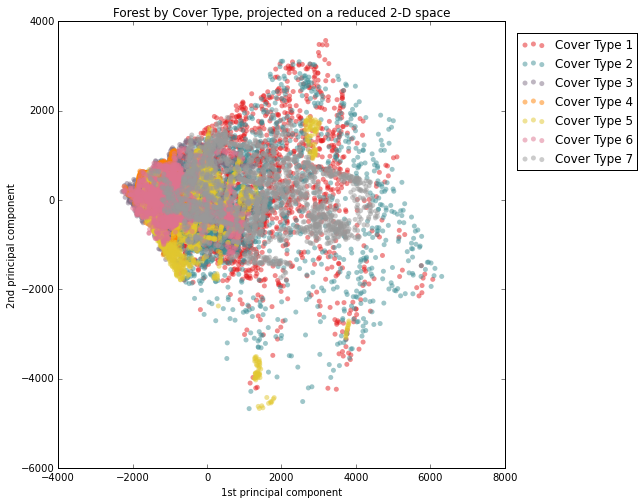

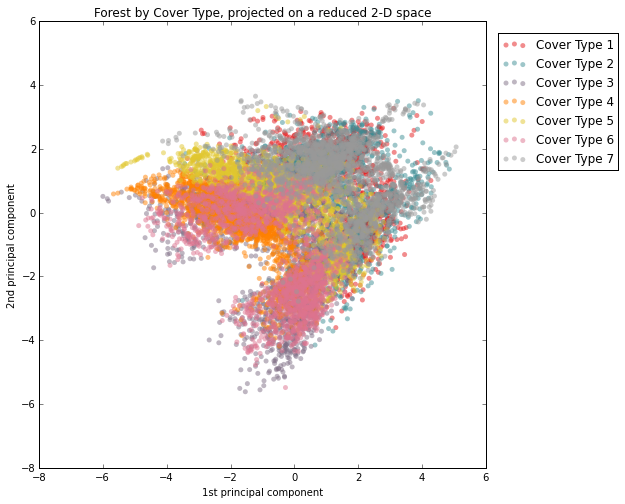

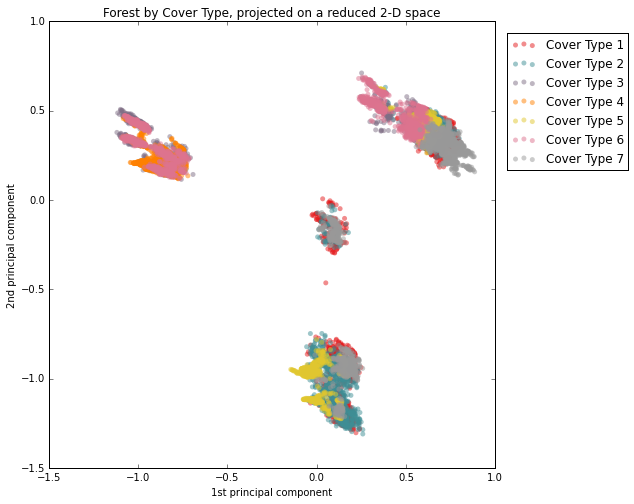

In [185]:
def plot(dataset):
    pc_2 = PCA(n_components=2)
    # Transform the coordinates into this new 2-D space
    X_train_2pc = pc_2.fit_transform(dataset)
    # Plot all elements of the training set in this 2-D space
    # Plot the projection of each forest in a 2-D space, with a color corresponding to each cover
        # type
    Colors = plt.cm.Set1(np.linspace(0, 1, len(np.unique(y_train))))
    # Each color is represented by 4 RGBA coordinates
    # cover_color = np.empty(4*X_train_2pc.shape[0]).reshape(X_train_2pc .shape[0], 4)
    # for i in np.arange(y_train.shape[0]):
        # color_index = y_train[i]-1
        # Each color is indexed by the cover type
        # cover_color[i,:] = Colors[color_index]
    plt.figure  (figsize = (8, 8))
    cover = np.empty(len(np.unique(y_train))).tolist()
    for i in range(len(np.unique(y_train))):
        cover[i] = plt.scatter (X_train_2pc[y_train==i+1,0], X_train_2pc[y_train==i+1,1],
                                c = Colors[i], alpha = 0.5, s=25, edgecolor='',
                                label = 'Cover Type ' + str(i+1))
    plt.xlabel("1st principal component")
    plt.ylabel("2nd principal component")
    plt.title('Forest by Cover Type, projected on a reduced 2-D space')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=1.)

plot(X_train)
plot(X_train_std)
plot(X_train_minmax)